In [233]:
%matplotlib inline
# IMPORTS
import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np

from scipy import sparse
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcess
#from sklearn.neural_network import MultilayerPerceptronClassifier

import matplotlib.pyplot as plt

TRAIN_DIR = "train"
TEST_DIR = "test"

call_set = set([])

In [234]:
# UTILITIES
# these are the fifteen malware classes we're looking for
malware_classes = ["Agent", "AutoRun", "FraudLoad", "FraudPack", "Hupigon", "Krap",
           "Lipler", "Magania", "None", "Poison", "Swizzor", "Tdss",
           "VB", "Virut", "Zbot"]

# a function for writing predictions in the required format
def write_predictions(predictions, ids, outfile):
    """
    assumes len(predictions) == len(ids), and that predictions[i] is the
    index of the predicted class with the malware_classes list above for 
    the executable corresponding to ids[i].
    outfile will be overwritten
    """
    with open(outfile,"w+") as f:
        # write header
        f.write("Id,Prediction\n")
        for i, history_id in enumerate(ids):
            f.write("%s,%d\n" % (history_id, predictions[i]))

In [235]:
def add_to_set(tree):
    for el in tree.iter():
        call = el.tag
        call_set.add(call)

In [236]:
def create_data_matrix(start_index, end_index, direc="train"):
    X = None
    classes = []
    ids = [] 
    i = -1
    for datafile in os.listdir(direc):
        if datafile == '.DS_Store':
            continue

        i += 1
        if i < start_index:
            continue 
        if i >= end_index:
            break

        # extract id and true class (if available) from filename
        id_str, clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(malware_classes.index(clazz))

        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)

        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        add_to_set(tree)
        this_row = call_feats(tree)
        if X is None:
            X = this_row 
        else:
            X = np.vstack((X, this_row))

    return X, np.array(classes), ids

In [237]:
s = ''
for a_s in list(call_set):
    s += ", 'sc_" + a_s +"'"
print s

In [238]:
good_calls = ['recv_socket', 'create_open_file', 'sleep', 'open_scmanager', 'load_driver', 
              'get_host_by_addr', 'create_interface', 'create_mutex', 'set_value', 'enum_items', 
              'get_computer_name', 'read_value', 'write_value', 'change_service_config', 
              'copy_file', 'exit_windows', 'connect_share', 'enum_modules', 'bind_socket', 
              'enum_keys', 'delete_value', 'enum_types', 'open_service', 'processes', 
              'add_share', 'create_socket', 'enum_user', 'dump_line', 'unload_driver', 
              'enum_values', 'thread', 'load_dll', 'create_window', 'read_section_names', 
              'com_create_instance', 'message', 'get_userinfo', 'get_file_attributes', 'find_file', 
              'open_file', 'get_username', 'create_service', 'query_value', 'create_file', 
              'move_file', 'open_key', 'send_socket', 'vm_write', 'delete_file', 
              'create_process_as_user', 'get_system_time', 'create_mailslot', 'com_createole_object', 
              'listen_socket', 'enum_share', 'open_mutex', 'vm_protect', 'all_section', 
              'vm_mapviewofsection', 'get_windows_directory', 'enum_processes', 'open_url', 
              'download_file', 'com_get_class_object', 'kill_process', 'load_image', 'delete_share', 
              'create_process', 'logon_as_user', 'get_system_directory', 'set_thread_context', 
              'create_process_nt', 'destroy_window', 'vm_allocate', 'enum_handles', 'connect_socket', 
              'set_file_time', 'start_service', 'create_thread_remote', 'show_window', 'open_process', 
              'impersonate_user', 'connect', 'enum_services', 'process', 'vm_read', 'check_for_debugger', 
              'query_keyinfo', 'delete_service', 'read_section', 'enum_window', 'set_system_time', 
              'add_netjob', 'ping', 'set_windows_hook', 'control_service', 'accept_socket', 
              'trimmed_bytes', 'download_file_to_cache', 'find_window', 'get_host_by_name', 
              'set_file_attributes', 'revert_to_self', 'create_key', 'create_thread', 'enum_subtypes', 
              'delete_key', 'create_directory', 'remove_directory', 'create_namedpipe']

In [239]:
other_features = ['Administrator', 'SYSTEM', 'NETZWERKDIENST', 'LOKALER DIENST', 
                  'SCM', 'InjectedCode', 'SvcHost', 'CreateProcess', 'BHOInstalled', 'DCOMService', 'AnalysisTarget',
                 'NormalTermination', 'Unknown', 'KilledByWindowsLoader', 'Timeout']

In [240]:
first_calls = ['fc_recv_socket', 'fc_create_open_file', 'fc_sleep', 'fc_open_scmanager', 'fc_load_driver', 'fc_get_host_by_addr', 'fc_create_interface', 'fc_create_mutex', 'fc_set_value', 'fc_enum_items', 'fc_get_computer_name', 'fc_read_value', 'fc_write_value', 'fc_change_service_config', 'fc_copy_file', 'fc_exit_windows', 'fc_connect_share', 'fc_enum_modules', 'fc_bind_socket', 'fc_enum_keys', 'fc_delete_value', 'fc_enum_types', 'fc_open_service', 'fc_processes', 'fc_add_share', 'fc_create_socket', 'fc_enum_user', 'fc_dump_line', 'fc_unload_driver', 'fc_enum_values', 'fc_thread', 'fc_load_dll', 'fc_create_window', 'fc_read_section_names', 'fc_com_create_instance', 'fc_message', 'fc_get_userinfo', 'fc_get_file_attributes', 'fc_find_file', 'fc_open_file', 'fc_get_username', 'fc_create_service', 'fc_query_value', 'fc_create_file', 'fc_move_file', 'fc_open_key', 'fc_send_socket', 'fc_vm_write', 'fc_delete_file', 'fc_create_process_as_user', 'fc_get_system_time', 'fc_create_mailslot', 'fc_com_createole_object', 'fc_listen_socket', 'fc_enum_share', 'fc_open_mutex', 'fc_vm_protect', 'fc_all_section', 'fc_vm_mapviewofsection', 'fc_get_windows_directory', 'fc_enum_processes', 'fc_open_url', 'fc_download_file', 'fc_com_get_class_object', 'fc_kill_process', 'fc_load_image', 'fc_delete_share', 'fc_create_process', 'fc_logon_as_user', 'fc_get_system_directory', 'fc_set_thread_context', 'fc_create_process_nt', 'fc_destroy_window', 'fc_vm_allocate', 'fc_enum_handles', 'fc_connect_socket', 'fc_set_file_time', 'fc_start_service', 'fc_create_thread_remote', 'fc_show_window', 'fc_open_process', 'fc_impersonate_user', 'fc_connect', 'fc_enum_services', 'fc_process', 'fc_vm_read', 'fc_check_for_debugger', 'fc_query_keyinfo', 'fc_delete_service', 'fc_read_section', 'fc_enum_window', 'fc_set_system_time', 'fc_add_netjob', 'fc_ping', 'fc_set_windows_hook', 'fc_control_service', 'fc_accept_socket', 'fc_trimmed_bytes', 'fc_download_file_to_cache', 'fc_find_window', 'fc_get_host_by_name', 'fc_set_file_attributes', 'fc_revert_to_self', 'fc_create_key', 'fc_create_thread', 'fc_enum_subtypes', 'fc_delete_key', 'fc_create_directory', 'fc_remove_directory', 'fc_create_namedpipe']

In [241]:
second_calls = ['sc_recv_socket', 'sc_create_open_file', 'sc_sleep', 'sc_open_scmanager', 'sc_load_driver', 'sc_get_host_by_addr', 'sc_create_interface', 'sc_create_mutex', 'sc_set_value', 'sc_enum_items', 'sc_get_computer_name', 'sc_read_value', 'sc_write_value', 'sc_change_service_config', 'sc_copy_file', 'sc_exit_windows', 'sc_connect_share', 'sc_enum_modules', 'sc_bind_socket', 'sc_enum_keys', 'sc_delete_value', 'sc_enum_types', 'sc_open_service', 'sc_processes', 'sc_add_share', 'sc_create_socket', 'sc_enum_user', 'sc_dump_line', 'sc_unload_driver', 'sc_enum_values', 'sc_thread', 'sc_load_dll', 'sc_create_window', 'sc_read_section_names', 'sc_com_create_instance', 'sc_message', 'sc_get_userinfo', 'sc_get_file_attributes', 'sc_find_file', 'sc_open_file', 'sc_get_username', 'sc_create_service', 'sc_query_value', 'sc_create_file', 'sc_move_file', 'sc_open_key', 'sc_send_socket', 'sc_vm_write', 'sc_delete_file', 'sc_create_process_as_user', 'sc_get_system_time', 'sc_create_mailslot', 'sc_com_createole_object', 'sc_listen_socket', 'sc_enum_share', 'sc_open_mutex', 'sc_vm_protect', 'sc_all_section', 'sc_vm_mapviewofsection', 'sc_get_windows_directory', 'sc_enum_processes', 'sc_open_url', 'sc_download_file', 'sc_com_get_class_object', 'sc_kill_process', 'sc_load_image', 'sc_delete_share', 'sc_create_process', 'sc_logon_as_user', 'sc_get_system_directory', 'sc_set_thread_context', 'sc_create_process_nt', 'sc_destroy_window', 'sc_vm_allocate', 'sc_enum_handles', 'sc_connect_socket', 'sc_set_file_time', 'sc_start_service', 'sc_create_thread_remote', 'sc_show_window', 'sc_open_process', 'sc_impersonate_user', 'sc_connect', 'sc_enum_services', 'sc_process', 'sc_vm_read', 'sc_check_for_debugger', 'sc_query_keyinfo', 'sc_delete_service', 'sc_read_section', 'sc_enum_window', 'sc_set_system_time', 'sc_add_netjob', 'sc_ping', 'sc_set_windows_hook', 'sc_control_service', 'sc_accept_socket', 'sc_trimmed_bytes', 'sc_download_file_to_cache', 'sc_find_window', 'sc_get_host_by_name', 'sc_set_file_attributes', 'sc_revert_to_self', 'sc_create_key', 'sc_create_thread', 'sc_enum_subtypes', 'sc_delete_key', 'sc_create_directory', 'sc_remove_directory', 'sc_create_namedpipe']

In [242]:
call_pairs = np.array(map(lambda call_one: map(lambda call_two: "fc_" + call_one + "_sc_" + call_two, good_calls), good_calls)).flatten().tolist()

In [248]:
all_features = good_calls + other_features + first_calls + second_calls + call_pairs

In [249]:
def add_count(feature_dict, feature_name):
    if feature_name not in feature_dict:
        feature_dict[feature_name] = 1
    else:
        feature_dict[feature_name] += 1
    return feature_dict

In [250]:
def call_feats(tree):
    
#     bigram_calls = []
#     for a_call in good_calls:
#         for b_call in good_calls:
#             bigram_calls.append(a_call + '_' + b_call)
            
#     combined_calls = good_calls + bigram_calls

    # Add calls
    feature_dict = {}
    last_call='start'
    for el in tree.iter():
        call = el.tag
        feature_dict = add_count(feature_dict, call)
            
    # Add other features
    root = tree.getroot()
    for process in root.findall('process[@username]'):
        username = process.attrib['username']
        feature_dict = add_count(feature_dict, username)
    for process in root.findall('process[@startreason]'):
        startreason = process.attrib['startreason']
        feature_dict = add_count(feature_dict, startreason)
    for process in root.findall('process[@terminationreason]'):
        terminationreason = process.attrib['terminationreason']
        feature_dict = add_count(feature_dict, terminationreason)
    j = 0
    # First non-'load_image' or 'load_dll' call
    for call in root.findall('process/thread/all_section/'):
        name = call.tag
        if (name != 'load_image') and (name != 'load_dll'): 
            j += 1
            if j == 1:
                first_call = 'fc_' + name
                feature_dict = add_count(feature_dict, first_call)
            if j == 2:
                second_call = 'sc_' + name
                feature_dict = add_count(feature_dict, second_call)
                break

    # Attempt to add call-pairs, which, in theory, help account for sequencing of calls.
    # This perhaps should be extended to call-triplets, etc.
    for idx, call in enumerate(root.findall('process/thread/all_section/')):
        if idx == 1:
            second_call = call.tag
        elif idx >= 2:
            first_call = second_call
            second_call = call.tag
            call_pair = "fc_" + first_call + "_sc_" + second_call
            feature_dict = add_count(feature_dict, call_pair)
                                
#         # Bigram Calls
#         combo = last_call + '_' + call
#         if combo not in call_counter:
#             call_counter[combo] = 1
#         #else:
#         #    call_counter[combo] += 1
#         last_call = call
            
    call_feat_array = np.zeros(len(all_features))
    for i in range(len(all_features)):
        call = all_features[i]
        call_feat_array[i] = 0
        if call in feature_dict:
            call_feat_array[i] = feature_dict[call]

    return call_feat_array

## Import the data

In [251]:
# TRAINING DATA
X_train_all, t_train_all, train_all_ids = create_data_matrix(0, 10, TRAIN_DIR)
X_train, X_valid, t_train, t_valid = train_test_split(X_train_all, t_train_all, test_size=0.20, random_state=37)

In [253]:
print 'Data matrix (training set):'
print X_train.shape
print 'Classes (training set):'
print t_train.shape

Data matrix (training set):
(8, 12445)
Classes (training set):
(8,)


In [673]:
# TESTING DATA
X_test_all, t_test_all, test_all_ids = create_data_matrix(0, 3724, TEST_DIR)

## Exploratory Data Analysis

In [652]:
# Sandbox
from sets import Set
i = -1
terminationreasons = Set([])

for datafile in os.listdir(TRAIN_DIR):
    
    if datafile == '.DS_Store':
        continue

    # extract id and true class (if available) from filename
    id_str, clazz = datafile.split('.')[:2]

    i += 1
    if i < 1:
        continue 
    if i >= 10:
        break
    print '---------'
    tree = ET.parse(os.path.join(TRAIN_DIR,datafile))
    root = tree.getroot()
    #for child in root.getchildren():
    #    print child.tag
    j = 0
    for call in root.findall('process/thread/all_section/'):
        #print thread.get(1).tag
        name = call.tag
        if (name != 'load_image') and (name != 'load_dll'):
            print j, name
            j += 1
            if j > 1:
                break
#        for child in thread.getchildren():
#            print child.tag
            #break
        #terminationreasons.add(process.attrib['terminationreason'])
        #print time(process.attrib['terminationtime']) - time(process.attrib['starttime'])
        #print process.attrib
#        for username in process.findall('username'):
#            print username.attrib
        #sername = child.find('username')
#        print process.attrib['username'] == 'Administrator'
        #print process.attrib['username'] == 'SYSTEM'
    
#     # parse file as an xml document
#     tree = ET.parse(os.path.join(direc,datafile))
#     add_to_set(tree)
#     this_row = call_feats(tree)
#     if X is None:
#         X = this_row 
#     else:
#         X = np.vstack((X, this_row))
print terminationreasons

---------
0 create_thread
1 vm_protect
---------
0 check_for_debugger
1 get_system_directory
---------
0 check_for_debugger
1 get_system_directory
---------
0 vm_protect
1 vm_protect
---------
0 get_file_attributes
---------
0 open_file
1 check_for_debugger
---------
0 check_for_debugger
1 get_system_directory
---------
0 create_thread
1 check_for_debugger
---------
0 open_file
1 check_for_debugger
Set([])


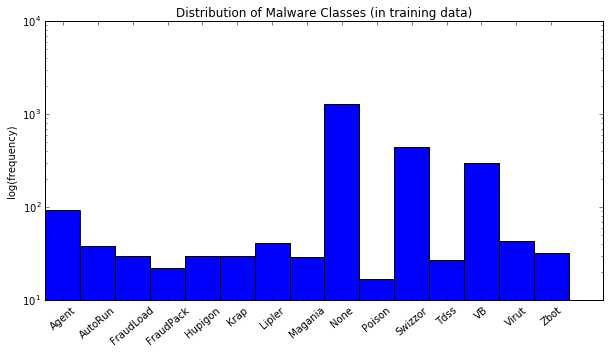

In [89]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.hist(t_train,bins = range(len(malware_classes)+1))
ax.set_xticklabels(malware_classes,rotation = 40)
ax.set_xticks(.5 + np.arange(len(malware_classes)))
ax.set_yscale('log')
ax.set_ylabel('log(frequency)')
plt.title('Distribution of Malware Classes (in training data)')
plt.show()

## Test the models

In [87]:
def plot_misclassified(model):
    ## take a look at the classes from which our misclassifieds came from
    misclassified_indices = np.nonzero(1*(model.predict(X_valid) != t_valid))[0]
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.hist(t_valid[misclassified_indices],bins = range(len(malware_classes)+1))
    ax.set_xticklabels(malware_classes,rotation = 40)
    ax.set_xticks(.5 + np.arange(len(malware_classes)))

    ax.set_ylabel('frequency')
    plt.title('Distribution of misclassified classes (in validation data)')
    plt.show()

In [674]:
# Try SVM
clf = svm.SVC(kernel='poly')
clf.fit(X_train, t_train)
print "SVM"
print "Score of validation set: %f" % clf.score(X_valid, t_valid)

SVM
Score of validation set: 0.822006


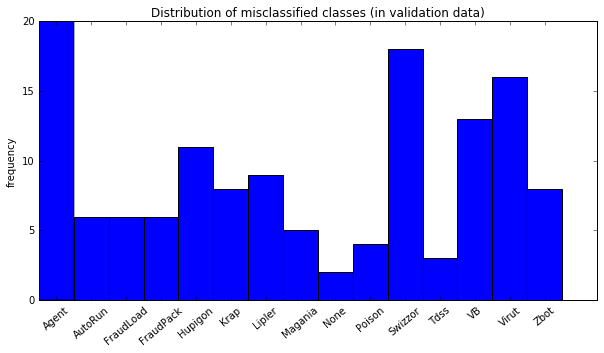

In [88]:
plot_misclassified(clf)

### Random Forests

In [660]:
# Random Forest Classifier
print "Random Forests"
ns = [1,5,7,8,9,10,11,12,13,14,15,18,20,22,25,27,30,35,40,50,100,200]
for n in ns:
    rf = RandomForestClassifier(n_estimators=n, random_state=37)
    rf.fit(X_train, t_train)
    print "For n = %d, score was: %f" % (n, rf.score(X_valid, t_valid))

Random Forests
For n = 1, score was: 0.846278
For n = 5, score was: 0.875405
For n = 7, score was: 0.880259
For n = 8, score was: 0.878641
For n = 9, score was: 0.875405
For n = 10, score was: 0.875405
For n = 11, score was: 0.885113
For n = 12, score was: 0.877023
For n = 13, score was: 0.877023
For n = 14, score was: 0.883495
For n = 15, score was: 0.888350
For n = 18, score was: 0.878641
For n = 20, score was: 0.880259
For n = 22, score was: 0.883495
For n = 25, score was: 0.883495
For n = 27, score was: 0.885113
For n = 30, score was: 0.889968
For n = 35, score was: 0.885113
For n = 40, score was: 0.886731
For n = 50, score was: 0.881877
For n = 100, score was: 0.881877
For n = 200, score was: 0.885113


## Metrics

### First Call

KAGGLE - 0.82263

### Second Call
n_estimators=30, min_samples_split=1, random_state=37 <br />
Score was: 0.889968 <br />
KAGGLE - 0.82000

In [672]:
rf = RandomForestClassifier(n_estimators=30, min_samples_split=1, random_state=37)
rf.fit(X_train, t_train)
print "Score was: %f" % (rf.score(X_valid, t_valid))

Score was: 0.889968


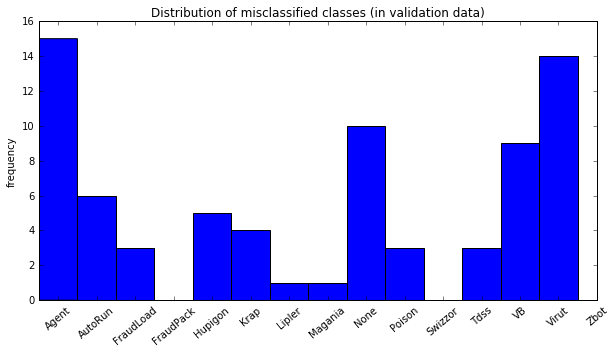

In [648]:
plot_misclassified(rf)

### Neural Network

In [634]:
# mlp = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
# mlp.fit(X_train, t_train)
# print "Score was: %f" % (mlp.score(X_valid, t_valid))

### Logisitic Regression

In [602]:
lr = LogisticRegression(penalty='l2',solver='newton-cg',max_iter=500)
lr.fit(X_train, t_train)
print "Score was: %f" % (lr.score(X_valid, t_valid))

Score was: 0.844660


In [603]:
lr = LogisticRegression(penalty='l1')
lr.fit(X_train, t_train)
print "Score was: %f" % (lr.score(X_valid, t_valid))

Score was: 0.864078


### Gaussian Process

In [287]:
gp = GaussianProcess()#theta0=0.1, thetaL=.001, thetaU=1.)
gp.fit(X_train, t_train)
print "Score was: %f" % (gp.score(X_valid, t_valid))

Exception: Multiple input features cannot have the same target value.

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, t_train)
print "Score was: %f" % (clf.score(X_valid, t_valid))

### KNC

In [611]:
# Try KNeighborsClassifier
ns = [1,2,3,4,5,6,7,8,10,20,25,30,50,100,200]
kneighborsscores = []
print "KNeighborsClassifier"
for n in ns:
    nn = KNeighborsClassifier(n_neighbors=n, weights='distance')
    nn.fit(X_train, t_train)
    score = nn.score(X_valid, t_valid)
    kneighborsscores.append(score)
    print "For n = %d, score was: %f" % (n, score)

KNeighborsClassifier
For n = 1, score was: 0.849515
For n = 2, score was: 0.849515
For n = 3, score was: 0.864078
For n = 4, score was: 0.862460
For n = 5, score was: 0.873786
For n = 6, score was: 0.864078
For n = 7, score was: 0.860841
For n = 8, score was: 0.868932
For n = 10, score was: 0.860841
For n = 20, score was: 0.854369
For n = 25, score was: 0.854369
For n = 30, score was: 0.846278
For n = 50, score was: 0.831715
For n = 100, score was: 0.822006
For n = 200, score was: 0.800971


In [612]:
kneighborsscores2 = []
nn = KNeighborsClassifier(n_neighbors=6, weights='distance')
nn.fit(X_train, t_train)
score = nn.score(X_valid, t_valid)
kneighborsscores2.append(score)
print "Score was: %f" % (score)

Score was: 0.864078


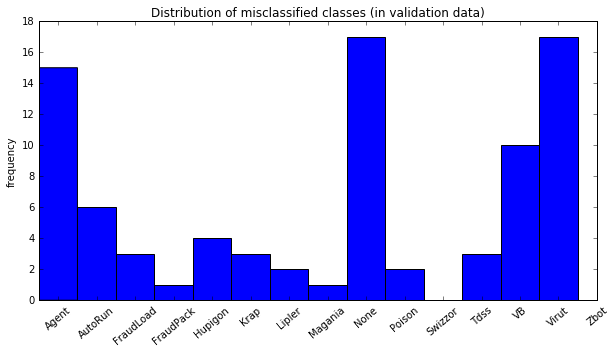

In [613]:
plot_misclassified(nn)

In [614]:
kneighborsscores2 = []
nn = KNeighborsClassifier(n_neighbors=6, weights='uniform')
nn.fit(X_train, t_train)
score = nn.score(X_valid, t_valid)
kneighborsscores2.append(score)
print "Score was: %f" % (score)

Score was: 0.851133


In [615]:
from sklearn.neighbors import RadiusNeighborsClassifier
rnc = RadiusNeighborsClassifier(radius=6,outlier_label=8, p=2)
rnc.fit(X_train, t_train)
print "Score was: %f" % (rnc.score(X_valid, t_valid))

Score was: 0.752427


## Generate Predictions

In [ ]:
# # Generate predictions on test set for the best model

# nn = KNeighborsClassifier(n_neighbors=6, weights='distance', p=1)
# nn.fit(X_train_all, t_train_all)
# test_predictions = nn.predict(X_test_all)

In [675]:
rf = RandomForestClassifier(n_estimators=30, min_samples_split=1)
rf.fit(X_train_all, t_train_all)
test_predictions = rf.predict(X_test_all)

In [676]:
def write_to_file(filename, ids, predictions):
    zips = zip(ids, predictions)
    with open(filename, "w") as f:
        f.write("Id,Prediction\n")
        for i,p in enumerate(zips):
            f.write(str(p[0]) + "," + str(p[1]) + "\n")

In [677]:
write_to_file("prediction.csv", test_all_ids, test_predictions)